# 导入依赖库后，可直接从MLP开始运行

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from clickhouse_driver import Client
import collections
import pymysql
import time
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',10)
import warnings
warnings.filterwarnings("ignore")
#连接clickhouse
# clickhouse_client = Client(host='10.10.119.207',port='9000',user='fjut',password='abc123,./' )
# #连接mysql 
# mysql_client = pymysql.connect(host="10.10.119.207", port=3306,user="root", passwd= "FJUT_highway_123" )
# cursor = mysql_client.cursor()

In [5]:
#判断名称连贯性
def NC(x):
    A = x['from_name']
    B = x['to_name']
    ft,tt = x['from_type'],x['to_type']
    if ft == 0 and intersection(A,B.split('至')[0]):
        return 1
    elif tt == 1 and intersection(B,A.split('至')[-1]):
        return 1
    else:
        if A.split('至')[-1] == (B.split('至')[0]):
            return 1
        elif A.split('至')[-1].startswith(B.split('至')[0]) or B.split('至')[0].startswith(A.split('至')[-1]):
            return 1
        else:
            return 0
#定义一个函数以确定两个字符串是否相交
def intersection(string1, string2): 
    # set to store characters of first string 
    set1 = set() 
    # loop through characters of first string and add them to set1 
    for char in string1: 
        set1.add(char) 
    # loop through characters of second string and 
    # check if character is present in set1 
    for char in string2: 
        if char in set1: 
            return True
    # if no common characters present, return false 
    return False

In [2]:
topo_cnt =  pd.read_csv(f'输出/所有节点数据/全部2-3.csv',index_col=0)
topo_list_from = pd.read_csv(f'输出/所有节点数据/归一化_from_标准归一化2-4.csv',index_col=0)
topo_list_to = pd.read_csv(f'输出/所有节点数据/归一化_to_标准归一化2-3.csv',index_col=0)

In [3]:
dff = topo_list_from[['road_section', 'nor']].rename(columns = {'nor' : 'FNR'},inplace = False)
dft = topo_list_to[['road_section', 'nor']].rename(columns = {'nor' : 'TNR'},inplace = False)

In [6]:
df3 = pd.merge(topo_cnt, dff, how='left', on='road_section')
df4 = pd.merge(df3, dft, how='left', on='road_section')
result_data = df4[(df4['FNR']>0)&(df4['TNR']>0)&(df4['ratio']>0)&(df4['cnt2']>5)]
result_data['NC'] = result_data.apply(NC,axis=1)
result_data['label'] = -1
# result_data.to_csv('输出/所有节点数据/FNR_TNR_0_RATIO_0_PASSNUM_5.csv',encoding='utf_8_sig')
# result_data[result_data['NC']==0]

In [ ]:
part_result = result_data.sample(frac=0.01, random_state=20)
part_result
# part_result.to_csv('输出/所有节点数据/百分之一数据.csv',encoding='utf_8_sig')

In [ ]:
data.sort_values(by='cnt2')

In [ ]:
data[data['label']!=-1]

In [ ]:
data.drop('NC',axis=1)

In [3]:
data

,cnt2,ratio,FNR,TNR,label
113,8175,1.000000,1.0000,0.3122,1
3393,19,0.575758,0.0201,0.0002,0
3399,26,0.896552,0.0245,0.0002,0
3414,17,0.850000,0.0144,0.0001,0
3375,32,0.888889,0.0119,0.0003,0
...,...,...,...,...,...
2358,220,1.000000,0.3782,0.1470,1
1717,538,1.000000,0.3791,0.9416,1
1790,519,1.000000,0.9001,0.3520,1
2534,149,1.000000,0.1357,0.1733,1


In [6]:
#将标注好的3432个拓扑放入训练,并且舍弃NC特征
data = pd.read_csv('输出/拓扑验证/四个特征结果加最短路径227已打标签.csv', index_col=0)
data = data[data['label']!=-1].iloc[:, -11:-5]
data = data.drop('NC',axis=1)
data

,cnt2,ratio,FNR,TNR,label
3393,19,0.575758,0.0201,0.0002,0
3399,26,0.896552,0.0245,0.0002,0
3414,17,0.850000,0.0144,0.0001,0
3375,32,0.888889,0.0119,0.0003,0
3382,28,0.682927,0.0508,0.0002,0
...,...,...,...,...,...
2358,220,1.000000,0.3782,0.1470,1
1717,538,1.000000,0.3791,0.9416,1
1790,519,1.000000,0.9001,0.3520,1
2534,149,1.000000,0.1357,0.1733,1


In [7]:
#将标注好的3432个拓扑放入训练,并且舍弃NC特征 五个特征
data = pd.read_csv('输出/拓扑验证/四个特征结果加最短路径227已打标签.csv', index_col=0)
data = data.rename(columns={"cnt2": "PN", "ratio": "PR", "FNR": "FNR", "TNR": "TNR"})
data = data[data['label']!=-1].iloc[:, -11:-2]
data = data.drop('NC',axis=1)
data = data[["PN", "PR", "FNR", "TNR", "label", "distance"]]

# 将LABEL列移动到最后一列
cols = data.columns.tolist()
cols.remove("label")
cols.append("label")
data = data[cols]

# 将distance列名改为大写
data = data.rename(columns={"distance": "DISTANCE"})
data

,PN,PR,FNR,TNR,DISTANCE,label
3393,19,0.575758,0.0201,0.0002,180119,0
3399,26,0.896552,0.0245,0.0002,201393,0
3414,17,0.850000,0.0144,0.0001,184044,0
3375,32,0.888889,0.0119,0.0003,195330,0
3382,28,0.682927,0.0508,0.0002,137231,0
...,...,...,...,...,...,...
2358,220,1.000000,0.3782,0.1470,1111,1
1717,538,1.000000,0.3791,0.9416,1343,1
1790,519,1.000000,0.9001,0.3520,1357,1
2534,149,1.000000,0.1357,0.1733,1802,1


# MLP多层感知机

Epoch 1/200
1/1 [==============================] - 0s 2ms/step - loss: 1.1397 - accuracy: 0.2764
Epoch 2/200
1/1 [==============================] - 0s 0s/step - loss: 1.1224 - accuracy: 0.3015
Epoch 3/200
1/1 [==============================] - 0s 0s/step - loss: 1.1039 - accuracy: 0.4348
Epoch 4/200
1/1 [==============================] - 0s 1000us/step - loss: 1.0880 - accuracy: 0.5692
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 1.0721 - accuracy: 0.6548
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 1.0586 - accuracy: 0.6890
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 1.0438 - accuracy: 0.7167
Epoch 8/200
1/1 [==============================] - 0s 1000us/step - loss: 1.0286 - accuracy: 0.7433
Epoch 9/200
1/1 [==============================] - 0s 1ms/step - loss: 1.0140 - accuracy: 0.7706
Epoch 10/200
1/1 [==============================] - 0s 0s/step - loss: 1.0005 - accuracy: 0.7993
Epoch 11/200
1/1 [========

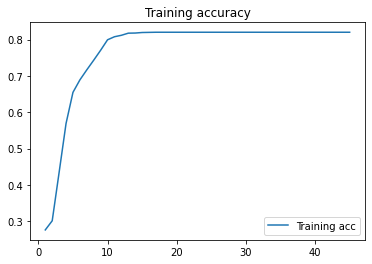

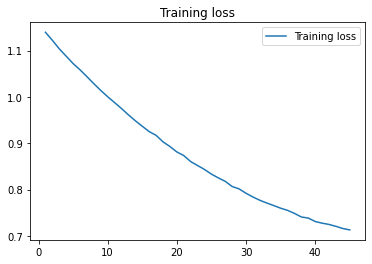

22/22 [==============================] - 0s 409us/step - loss: 0.6757 - accuracy: 0.8426
测试损失: 0.6757021546363831 测试准确率: 0.8425655961036682


In [2]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# # 80门架作为训练数据
# data = pd.read_excel('输入/test.xlsx').iloc[:, -6:]


# 所有节点中的1%为数据
# data = pd.read_csv('输出/所有节点数据/百分之一数据.csv', index_col=0).iloc[:, -6:]

# 随机抽取80%的数据
train_data = data.sample(frac=0.8, random_state=0)
# 计算剩余的20%的数据
test_data = data.drop(train_data.index)
# 训练标签
train_label = train_data.iloc[:, -1]
# 测试标签
test_label = test_data.iloc[:, -1]
# 删除标签
train_data = train_data.drop(['label'], axis=1)
test_data = test_data.drop(['label'], axis=1)
# # 归一化
train_data = (train_data - train_data.min()) /(train_data.max() - train_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
# 训练样本数
train_num = train_data.shape[0]
# # 测试样本数
test_num = test_data.shape[0]
# # 特征数
feature_num = train_data.shape[1]
# # 训练样本
x_train = train_data.values
# # 测试样本
x_test = test_data.values
# # 训练标签
y_train = train_label.values
# # 测试标签
y_test = test_label.values
# # 将标签转化为one-hot编码
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# # 定义模型
# 这段代码正在构建一个具有两个隐藏层和一个输出层的前馈神经网络（MLP）。
# 隐蔽层各有32个神经元，输出层有两个神经元。隐蔽层的激活函数是ReLU，而输出层的激活函数是softmax。


def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, input_shape=(
            4,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation=tf.nn.relu,
                              kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.l2(0.01))])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    return model


# # 训练模型
model = build_model()
callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', patience=30, min_delta=0.001)
history = model.fit(x_train, y_train, batch_size=train_num,
                    epochs=200, callbacks=[callback])

# 绘制训练过程中的损失和准确率
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, '-', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

# 测试模型
loss, acc = model.evaluate(x_test, y_test)

print('测试损失:', loss, '测试准确率:', acc)

In [154]:
#保存模型
model.save_weights(f'model/weights{acc}.h5')
model.save(f'model/model_acc{acc}.h5')

In [155]:
# model_saved = tf.keras.models.load_model(f'model/model_acc{acc}.h5')
# 提取输入特征
features = data.iloc[:, :-1]

# 归一化处理
features = (features - features.min()) / (features.max() - features.min())
# 对输入特征进行预测
predictions = model.predict(features)
# 提取预测结果中的类别（即哪个类别概率更大）
predicted_labels = tf.argmax(predictions, axis=1).numpy()
# 提取真实标签
true_labels = data.iloc[:, -1]

correct_count = 0
wrong_count = 0
# 输出哪些拓扑是真实的
for i in range(len(features)):
    if predicted_labels[i] == true_labels[i]:
#         print(f'Topology {i} is true')
        correct_count += 1
    else:
#         print(f'Topology {i} is false')
        wrong_count += 1
        
print('预测正确的拓扑数:', correct_count)
print('预测错误的拓扑数:', wrong_count)
print('准确率:',correct_count/len(features))

预测正确的拓扑数: 2830
预测错误的拓扑数: 602
准确率: 0.8245920745920746


In [ ]:
data = pd.read_csv('输出/所有节点数据/百分之一数据.csv').iloc[:, -6:]
data

Epoch 1/100
1/1 [==============================] - 0s 1000us/step - loss: 0.6659 - accuracy: 0.7884
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6440 - accuracy: 0.7677
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6231 - accuracy: 0.8084
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 0.6032 - accuracy: 0.8201
Epoch 5/100
1/1 [==============================] - 0s 999us/step - loss: 0.5842 - accuracy: 0.8205
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.5662 - accuracy: 0.8201
Epoch 7/100
1/1 [==============================] - 0s 1000us/step - loss: 0.5492 - accuracy: 0.8201
Epoch 8/100
1/1 [==============================] - 0s 0s/step - loss: 0.5329 - accuracy: 0.8201
Epoch 9/100
1/1 [==============================] - 0s 999us/step - loss: 0.5178 - accuracy: 0.8201
Epoch 10/100
1/1 [==============================] - 0s 0s/step - loss: 0.5036 - accuracy: 0.8201
Epoch 11/100
1/1 [====

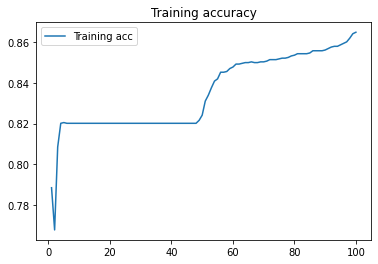

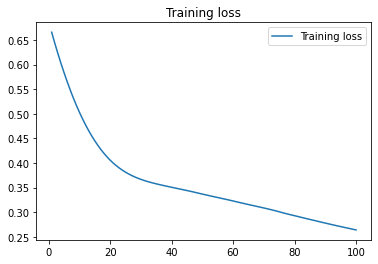

22/22 [==============================] - 0s 409us/step - loss: 0.2436 - accuracy: 0.8950
测试损失: 0.24362236261367798 测试准确率: 0.8950437307357788


In [11]:
#三层神经网络
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd

# # 训练数据
# train_data = pd.read_excel('输入/test.xlsx')
# train_data = train_data.iloc[:, 1:]
# # 测试数据
# test_data = pd.read_excel('输入/test.xlsx')
# test_data = test_data.iloc[:, 1:]

# data = pd.read_excel('输入/test.xlsx').iloc[:, 1:]
# 随机抽取80%的数据
train_data = data.sample(frac=0.8, random_state=0)
# 计算剩余的20%的数据
test_data = data.drop(train_data.index)
# 训练标签
train_label = train_data.iloc[:, -1]
# 测试标签
test_label = test_data.iloc[:, -1]
# 删除标签
train_data = train_data.drop(['label'], axis=1)
test_data = test_data.drop(['label'], axis=1)
# # 归一化
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
# 训练样本数
train_num = train_data.shape[0]
# # 测试样本数
test_num = test_data.shape[0]
# # 特征数
feature_num = train_data.shape[1]
# # 训练样本
x_train = train_data.values
# # 测试样本
x_test = test_data.values
# # 训练标签
y_train = train_label.values
# # 测试标签
y_test = test_label.values
# # 将标签转化为one-hot编码
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# # 定义模型
#这段代码正在构建一个具有两个隐藏层和一个输出层的前馈神经网络（MLP）。
# 隐蔽层各有32个神经元，输出层有两个神经元。隐蔽层的激活函数是ReLU，而输出层的激活函数是softmax。
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, input_shape=(4,)),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    return model


# # 训练模型
model = build_model()
history = model.fit(x_train, y_train, batch_size=train_num, epochs=100)

# 绘制训练过程中的损失和准确率
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, '-', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

# 测试模型
loss, acc = model.evaluate(x_test, y_test)

print('测试损失:', loss, '测试准确率:', acc)

# 随机森林

## 超参数寻优

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd


# 将数据拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data.drop('label', axis=1), data['label'], test_size=0.3, random_state=123)

# 使用Jiang's方法进行变量选择
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model.fit(X_train, y_train)
varImp = rf_model.feature_importances_
varImpOrder = sorted(range(len(varImp)), key=lambda k: varImp[k], reverse=True)
selectedVars = X_train.columns[varImpOrder][:4]

# 使用选定的变量来训练模型并进行预测
rf_model_selectedVars = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model_selectedVars.fit(X_train[selectedVars], y_train)
predictions = rf_model_selectedVars.predict(X_test[selectedVars])

# 计算模型的准确率和AUC值
accuracy_score(y_test,predictions)
roc_auc_score(y_test,predictions)

0.91230895805444

In [8]:
from sklearn.model_selection import GridSearchCV
# 进行超参数调优，可以使用网格搜索（Grid Search）或随机搜索（Random Search）
X = data.iloc[:, :-1]  # 特征
y = data.iloc[:, -1]  # 标签

# 定义参数空间
param_grid = {
    'n_estimators': range(100, 201, 50),
    'max_depth': range(5, 16, 4),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 初始化随机森林分类器
clf = RandomForestClassifier(random_state=0)

# 网格搜索
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X, y)

# 输出最佳参数和得分
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best score:  0.964737036424052


In [3]:
#将标注好的3432个拓扑放入训练,并且舍弃NC特征
data = pd.read_csv('输出/拓扑验证/四个特征结果加最短路径227已打标签.csv', index_col=0)
data = data.rename(columns={"cnt2": "PN", "ratio": "PR", "FNR": "FNR", "TNR": "TNR",'label':'LABEL'})
data = data[data['LABEL']!=-1].iloc[:, -11:-2]
data = data.drop('NC',axis=1)
data = data[["PN", "PR", "FNR", "TNR", "LABEL", "distance"]]

# 将LABEL列移动到最后一列
cols = data.columns.tolist()
cols.remove("LABEL")
cols.append("LABEL")
data = data[cols]

# 将distance列名改为大写
data = data.rename(columns={"distance": "DISTANCE"})
data

,PN,PR,FNR,TNR,DISTANCE,LABEL
3393,19,0.575758,0.0201,0.0002,180119,0
3399,26,0.896552,0.0245,0.0002,201393,0
3414,17,0.850000,0.0144,0.0001,184044,0
3375,32,0.888889,0.0119,0.0003,195330,0
3382,28,0.682927,0.0508,0.0002,137231,0
...,...,...,...,...,...,...
2358,220,1.000000,0.3782,0.1470,1111,1
1717,538,1.000000,0.3791,0.9416,1343,1
1790,519,1.000000,0.9001,0.3520,1357,1
2534,149,1.000000,0.1357,0.1733,1802,1


## 训练

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1] # 特征
y = data.iloc[:, -1] # 标签

# 使用最佳参数初始化随机森林分类器
clf = RandomForestClassifier(n_estimators=150, max_depth=5, min_samples_leaf=1, min_samples_split=5, random_state=0)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练分类器
clf.fit(X, y)

#对测试集进行预测
y_pred = clf.predict(X_test)

# 计算评估指标
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 输出评估指标
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9660194174757282
Precision: 0.9623529411764706
Recall: 0.9963459196102314
F1-score: 0.9790544584081389


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score

# 读取数据

# 提取特征与标签
X = data.drop('LABEL', axis=1)
y = data['LABEL']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 设置参数网格
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# 初始化随机森林分类器
rf = RandomForestClassifier()

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# 使用最佳参数训练模型
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

# 在测试集上评估模型
y_pred = best_rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("AUC-ROC: ", roc_auc_score(y_test, y_pred))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       209
           1       0.96      0.99      0.98       821

    accuracy                           0.96      1030
   macro avg       0.96      0.92      0.94      1030
weighted avg       0.96      0.96      0.96      1030

Confusion Matrix:
[[177  32]
 [  6 815]]
Accuracy Score:  0.9631067961165048
AUC-ROC:  0.9197908956867865


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       190
           1       0.96      1.00      0.98       840

    accuracy                           0.97      1030
   macro avg       0.97      0.91      0.94      1030
weighted avg       0.97      0.97      0.96      1030



Precision：精确率，是指预测为正样本的样本中，实际为正样本的比例。即 TP / (TP + FP)，其中 TP 为真正例，FP 为假正例。在这个例子中，对于预测为正样本的样本，有 96% 实际为正样本。

Recall：召回率，是指实际为正样本的样本中，被预测为正样本的比例。即 TP / (TP + FN)，其中 TP 为真正例，FN 为假负例。在这个例子中，对于所有实际为正样本的样本，有 100% 被预测为正样本。

F1-score：综合了精确率和召回率的指标，是精确率和召回率的调和平均数。即 2 * (Precision * Recall) / (Precision + Recall)。在这个例子中，正样本的 F1-score 是 0.98。
Support：每个类别的样本数。

Accuracy：准确率，是指分类器正确分类的样本数占总样本数的比例。即 (TP + TN) / (TP + TN + FP + FN)。在这个例子中，分类器的准确率是 0.97。

Macro avg：宏平均，是指对每个类别分别计算指标的平均值，然后对所有类别的平均值求平均。在这个例子中，宏平均的 F1-score 是 0.94。

Weighted avg：加权平均，是指对每个类别分别计算指标的平均值，然后按照每个类别的样本数进行加权平均。在这个例子中，加权平均的 F1-score 是 0.96。

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# 打印混淆矩阵
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 计算AUC-ROC值
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("AUC-ROC: {:.2f}".format(roc_auc))

Confusion Matrix:
 [[177  32]
 [  3 818]]
AUC-ROC: 0.99


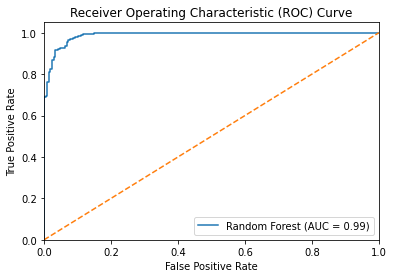

In [10]:
from sklearn.metrics import roc_curve, auc

# 计算FPR（假正例率）和TPR（真正例率）
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

# 计算AUC值
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


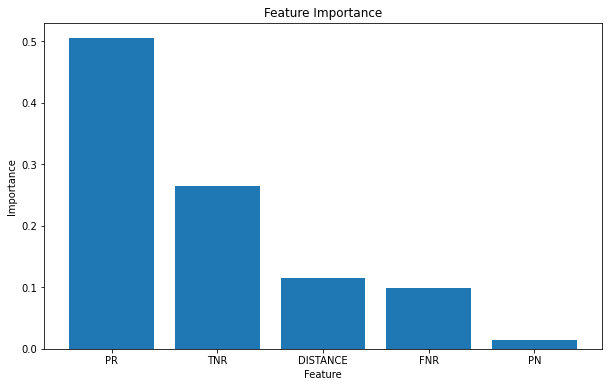

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 计算特征重要性
importances =clf.feature_importances_

# 特征名称
feature_names = X.columns

# 将特征重要性和特征名称打包，然后根据特征重要性进行排序
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# 绘制特征重要性柱状图
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()


In [ ]:
# 新的样本
sample = np.array([100000, 0.1, 0.02, 0.02]).reshape(1, -1)
# 预测标签
pred = clf.predict(sample)
print(pred)

# 梯度提升树

## 超参数寻优

In [35]:
X = data.iloc[:, :-1]  # 特征
y = data.iloc[:, -1]  # 标签

# 定义参数空间
param_grid = {
    'n_estimators': range(100, 201, 50),
    'max_depth': range(5, 16, 1),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 初始化梯度提升树分类器
clf = GradientBoostingClassifier(random_state=0)

# 网格搜索
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X, y)

# 输出最佳参数和得分
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best score:  0.9580319214398173


## 训练

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 分离特征和标签
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化梯度提升树分类器
clf = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=0)

# 训练分类器
clf.fit(X_train, y_train)

# 预测测试集
y_pred = clf.predict(X_test)

# 计算评估指标
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 输出评估指标
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.954368932038835
Precision: 0.9583815028901734
Recall: 0.986904761904762
F1-score: 0.972434017595308


# BAGGING模型

## 超参数寻优

In [39]:
# from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#BAGGING
base_clf = DecisionTreeClassifier(random_state=42)
bagging_clf = BaggingClassifier(base_estimator=base_clf, random_state=42)

# 设置超参数搜索范围
param_grid = {
    'n_estimators': range(50, 151, 50),
    'max_samples': [0.5, 0.6, 0.7],
    'max_features': [0.5, 0.6, 0.7],
}

# 初始化GridSearchCV对象
grid_search = GridSearchCV(bagging_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# 训练GridSearchCV对象
grid_search.fit(X_train, y_train)

# 输出最佳超参数和最佳得分
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_features': 0.5, 'max_samples': 0.6, 'n_estimators': 150}
Best score:  0.9616995841995843


## 训练

In [40]:
from sklearn.ensemble import BaggingClassifier
# 使用最佳超参数创建Bagging分类器
best_bagging_clf = BaggingClassifier(base_estimator=base_clf, n_estimators=grid_search.best_params_['n_estimators'],
                                      max_samples=grid_search.best_params_['max_samples'], 
                                      max_features=grid_search.best_params_['max_features'], random_state=42)

# 训练最佳Bagging分类器并预测测试集
best_bagging_clf.fit(X_train, y_train)
y_pred = best_bagging_clf.predict(X_test)

# 输出预测结果和性能评估指标
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.9611650485436893
Precision: 0.9576659038901602
Recall: 0.9964285714285714
F1-score: 0.9766627771295217


# 小提琴图

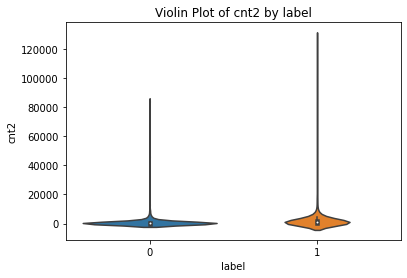

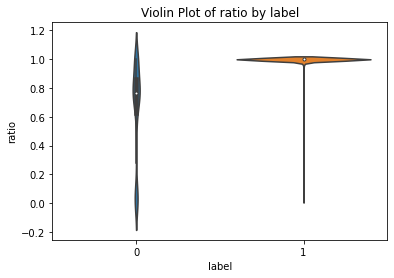

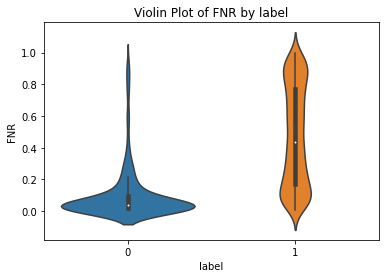

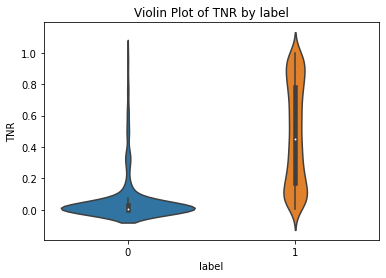

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x='label', y='cnt2', data=data)
plt.title('Violin Plot of cnt2 by label')
plt.show()
sns.violinplot(x='label', y='ratio', data=data)
plt.title('Violin Plot of ratio by label')
plt.show()
sns.violinplot(x='label', y='FNR', data=data)
plt.title('Violin Plot of FNR by label')
plt.show()
sns.violinplot(x='label', y='TNR', data=data)
plt.title('Violin Plot of TNR by label')
plt.show()

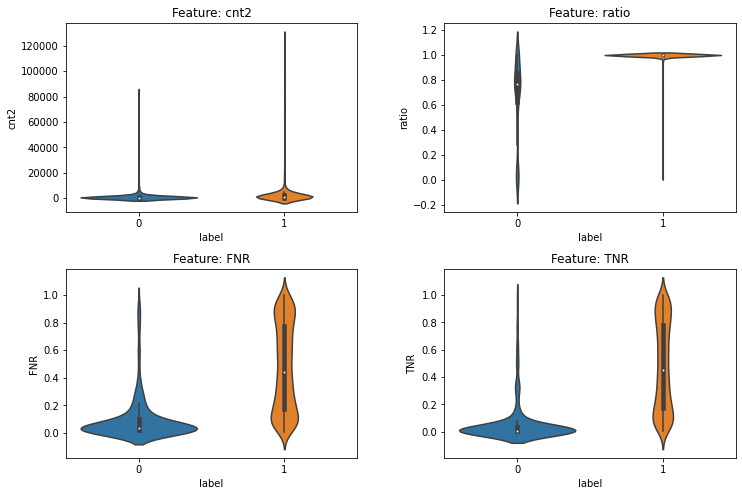

In [17]:
# 分别绘制四个特征的小提琴图
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.violinplot(x="label", y="cnt2", data=data, ax=axs[0, 0])
axs[0, 0].set_title("Feature: cnt2")

sns.violinplot(x="label", y="ratio", data=data, ax=axs[0, 1])
axs[0, 1].set_title("Feature: ratio")

sns.violinplot(x="label", y="FNR", data=data, ax=axs[1, 0])
axs[1, 0].set_title("Feature: FNR")

sns.violinplot(x="label", y="TNR", data=data, ax=axs[1, 1])
axs[1, 1].set_title("Feature: TNR")

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

In [31]:
data_origin = pd.read_csv('输出/拓扑验证/四个特征结果加最短路径227已打标签.csv', index_col=0)

In [25]:
data['cnt2_rank'] = data['cnt2'].rank(pct=True)
data['ratio_rank'] = data['ratio'].rank(pct=True)
data['FNR_rank'] = data['FNR'].rank(pct=True)
data['TNR_rank'] = data['TNR'].rank(pct=True)
data

,cnt2,ratio,FNR,TNR,label,cnt2_rank,ratio_rank,FNR_rank,TNR_rank
113,8175,1.000000,1.0000,0.3122,1,0.957896,0.665355,0.998397,0.484848
3393,19,0.575758,0.0201,0.0002,0,0.028846,0.045455,0.055507,0.010781
3399,26,0.896552,0.0245,0.0002,0,0.039773,0.142628,0.076632,0.010781
3414,17,0.850000,0.0144,0.0001,0,0.024476,0.134907,0.028992,0.003205
3375,32,0.888889,0.0119,0.0003,0,0.053030,0.141608,0.013258,0.017628
...,...,...,...,...,...,...,...,...,...
2358,220,1.000000,0.3782,0.1470,1,0.285693,0.665355,0.536713,0.333916
1717,538,1.000000,0.3791,0.9416,1,0.465763,0.665355,0.537587,0.932984
1790,519,1.000000,0.9001,0.3520,1,0.458770,0.665355,0.903555,0.513112
2534,149,1.000000,0.1357,0.1733,1,0.207605,0.665355,0.309878,0.368153


In [26]:
faulty_topologies = data[data['label'] == 0]
faulty_topologies['avg_rank'] = faulty_topologies[['cnt2_rank', 'ratio_rank', 'FNR_rank', 'TNR_rank']].mean(axis=1)
faulty_topologies

,cnt2,ratio,FNR,TNR,label,cnt2_rank,ratio_rank,FNR_rank,TNR_rank,avg_rank
3393,19,0.575758,0.0201,0.0002,0,0.028846,0.045455,0.055507,0.010781,0.035147
3399,26,0.896552,0.0245,0.0002,0,0.039773,0.142628,0.076632,0.010781,0.067453
3414,17,0.850000,0.0144,0.0001,0,0.024476,0.134907,0.028992,0.003205,0.047895
3375,32,0.888889,0.0119,0.0003,0,0.053030,0.141608,0.013258,0.017628,0.056381
3382,28,0.682927,0.0508,0.0002,0,0.044726,0.058858,0.154720,0.010781,0.067271
...,...,...,...,...,...,...,...,...,...,...
3418,8,0.500000,0.8421,0.0006,0,0.007284,0.042978,0.844551,0.032925,0.231935
3419,8,0.888889,0.4706,0.0029,0,0.007284,0.141608,0.596154,0.071241,0.204072
3370,7,1.000000,0.8750,0.9130,0,0.004079,0.665355,0.879953,0.906031,0.613855
3350,6,1.000000,0.9167,1.0000,0,0.001457,0.665355,0.923368,0.994755,0.646234


In [30]:
faulty_topologies['fault_rate'] = (faulty_topologies['avg_rank'] - faulty_topologies['avg_rank'].min()) / (faulty_topologies['avg_rank'].max() - faulty_topologies['avg_rank'].min())
faulty_topologies.sort_values(by='fault_rate')

,cnt2,ratio,FNR,TNR,label,cnt2_rank,ratio_rank,FNR_rank,TNR_rank,avg_rank,fault_rate
3412,15,0.428571,0.0109,0.0001,0,0.020979,0.041375,0.006993,0.003205,0.018138,0.000000
3406,16,0.640000,0.0111,0.0002,0,0.022727,0.049534,0.008741,0.010781,0.022946,0.006337
3428,11,0.733333,0.0105,0.0001,0,0.012966,0.072698,0.004079,0.003205,0.023237,0.006721
3421,11,0.733333,0.0124,0.0001,0,0.012966,0.072698,0.015880,0.003205,0.026187,0.010610
3408,6,0.049587,0.0133,0.0022,0,0.001457,0.028263,0.021853,0.062791,0.028591,0.013779
...,...,...,...,...,...,...,...,...,...,...,...
357,3654,0.998634,0.5551,0.7499,0,0.872960,0.249709,0.643357,0.766026,0.633013,0.810505
636,1986,0.997990,0.8004,0.7512,0,0.772582,0.231935,0.811043,0.767337,0.645724,0.827260
3350,6,1.000000,0.9167,1.0000,0,0.001457,0.665355,0.923368,0.994755,0.646234,0.827932
489,3216,0.993513,0.8888,0.6241,0,0.854312,0.183858,0.892045,0.685606,0.653955,0.838110
